## Self-Supervised: SwAV: Unsupervised Learning of Visual Features by Contrasting Cluster Assignments

- Explicação do SwAV:

[Minha explicação do SwAV](https://file.notion.so/f/f/587df413-8c1c-4843-8cff-e039e4cf710a/c2198b8e-a469-46fb-aa63-e8709a269bfb/swav_explained.pdf?table=block&id=29c6129e-dcd6-80d8-97fa-ee6b14794157&spaceId=587df413-8c1c-4843-8cff-e039e4cf710a&expirationTimestamp=1761854400000&signature=5t9Thz2m3dtBgm9TUDHqbZgiIyhS5ewRkKqFel1qvpY&downloadName=swav_explained.pdf) (deixei disponível no site também)

[Explicação de outra pessoa](https://theaisummer.com/swav/)

[Paper Original](https://arxiv.org/pdf/2006.09882)


- Explicações de transporte ótimo:

[Notes on Optimal Transport](https://michielstock.github.io/posts/2017/2017-11-5-OptimalTransport/)

[A Short Introduction to Optimal Transport](https://alexhwilliams.info/itsneuronalblog/2020/10/09/optimal-transport/)

In [1]:
#@title Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import transforms, datasets
from torchvision.models import resnet18

import matplotlib.pyplot as plt
import numpy as np
import random
import time
import os
from tqdm import trange, tqdm
from itertools import groupby

# Define a semente para reprodutibilidade
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Verifica a versão do PyTorch e se a GPU está disponível
print(f"PyTorch Version: {torch.__version__}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PyTorch Version: 2.8.0+cu128
Using device: cuda


In [2]:
class MultiCropDataAugmentation:
    def __init__(self, size_crops, num_crops, min_scale, max_scale):
        self.size_crops = size_crops
        self.num_crops = num_crops
        self.min_scale = min_scale
        self.max_scale = max_scale

        self.transforms = []
        for i in range(len(size_crops)):
            # Cria um pipeline de transformação para cada resolução de corte
            random_resized_crop = transforms.RandomResizedCrop(
                size_crops[i],
                scale=(min_scale[i], max_scale[i])
            )
            # Aumentos de dados padrão do SwAV
            self.transforms.append(transforms.Compose([
                random_resized_crop,
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomApply([transforms.ColorJitter(0.8, 0.8, 0.8, 0.2)], p=0.8),
                transforms.RandomGrayscale(p=0.2),
                transforms.RandomApply([transforms.GaussianBlur(kernel_size=23)], p=0.5),
                transforms.ToTensor(),
                # Normalização com as médias e desvios padrão do ImageNet
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ]))

    def __call__(self, x):
        # Aplica as transformações para gerar todas as visualizações
        all_crops = []
        # Primeiras 'num_crops[0]' transformações são de alta resolução
        for _ in range(self.num_crops[0]):
            all_crops.append(self.transforms[0](x))
        # As 'num_crops[1]' restantes são de baixa resolução
        for _ in range(self.num_crops[1]):
            all_crops.append(self.transforms[1](x))
        return all_crops

In [ ]:
# Configurações principais
BS = 2048
SIZE_CROPS = [32, 16]
NUM_CROPS = [2, 3]

# Escalas para os cortes
MIN_SCALE = [0.5, 0.3]
MAX_SCALE = [1.0, 0.5]

# Instancia a classe de aumento de dados
multi_crop_transform = MultiCropDataAugmentation(
    size_crops=SIZE_CROPS,
    num_crops=NUM_CROPS,
    min_scale=MIN_SCALE,
    max_scale=MAX_SCALE
)

# Carrega o dataset CIFAR-10
full_train_dataset = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=multi_crop_transform # Aplica nossa transformação multi-crop
)

# Pega apenas 50% dos dados para o treinamento do SwAV
subset_indices = list(range(int(len(full_train_dataset))))
train_ds = Subset(full_train_dataset, subset_indices)

# Cria o DataLoader
train_loader = DataLoader(
    train_ds,
    batch_size=BS,
    shuffle=True,
    num_workers=0, 
    pin_memory=True,
    drop_last=True
)

# Extrai um batch para verificar as dimensões
images_list = next(iter(train_loader))[0]
print(f"Número de visualizações (crops): {len(images_list)}")
for i, img_tensor in enumerate(images_list):
    print(f"  - Crop {i+1} shape: {img_tensor.shape}")

100%|██████████| 170M/170M [00:20<00:00, 8.15MB/s] 


Número de visualizações (crops): 5
  - Crop 1 shape: torch.Size([2048, 3, 32, 32])
  - Crop 2 shape: torch.Size([2048, 3, 32, 32])
  - Crop 3 shape: torch.Size([2048, 3, 16, 16])
  - Crop 4 shape: torch.Size([2048, 3, 16, 16])
  - Crop 5 shape: torch.Size([2048, 3, 16, 16])


In [5]:
class SwAVModel(nn.Module):
    # O valor padrão de in_features já está correto para a ResNet-18
    def __init__(self, in_features=128, dense_1=1024, dense_2=96, prototype_dim=15):
        super().__init__()

        # --- Parte do Backbone (ResNet-18) ---
        base_model = resnet18(weights='IMAGENET1K_V1') # Usando a ResNet-18
        self.backbone = nn.Sequential(
            base_model.conv1,
            base_model.bn1,
            base_model.relu,
            base_model.maxpool,
            base_model.layer1,
            base_model.layer2
        )
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        # --- Parte da Cabeça de Projeção e Protótipo ---
        # Esta parte agora espera corretamente in_features=128
        self.projection_head = nn.Sequential(
            nn.Linear(in_features, dense_1),
            nn.BatchNorm1d(dense_1),
            nn.ReLU(),
            nn.Linear(dense_1, dense_2)
        )
        self.prototype = nn.Linear(dense_2, prototype_dim, bias=False)

    def forward(self, x):
        features = self.backbone(x)
        features = self.pool(features)
        features = torch.flatten(features, 1)

        # Para depurar, você pode descomentar a linha abaixo e verificar a dimensão:
        # print(f"Shape do vetor de características: {features.shape}") # Deve ser [batch_size, 128]

        projection = self.projection_head(features)
        projection_normalized = F.normalize(projection, dim=1, p=2)
        prototype_output = self.prototype(projection_normalized)

        return projection_normalized, prototype_output

# --- CORREÇÃO NA INSTANCIAÇÃO ---
# Certifique-se de que in_features está definido como 128, correspondente à saída da layer2 do ResNet-18.
swav_model = SwAVModel(in_features=128, prototype_dim=15) #

print("--- Modelo SwAV com ResNet-18 ---")
print(swav_model)

--- Modelo SwAV com ResNet-18 ---
SwAVModel(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, a

In [6]:
@torch.no_grad()
def sinkhorn(sample_prototype_batch, epsilon=0.05, n_iters=3):
    Q = torch.exp(sample_prototype_batch / epsilon).t()
    B = Q.shape[1]
    K = Q.shape[0]

    sum_Q = torch.sum(Q)
    Q /= sum_Q

    r = torch.ones(K, device=device) / K
    c = torch.ones(B, device=device) / B

    for _ in range(n_iters):
        u = torch.sum(Q, dim=1)
        Q *= (r / u).unsqueeze(1)
        Q *= (c / torch.sum(Q, dim=0)).unsqueeze(0)

    final_Q = Q / torch.sum(Q, dim=0, keepdim=True)
    return final_Q.t()

In [8]:
def train_step(input_views, swav_model, optimizer, crops_for_assign, temperature):
    """
    Função de treinamento para um único passo (batch), CORRIGIDA para lidar com Múltiplas Resoluções.
    """
    # Move o modelo para o dispositivo correto
    swav_model.to(device)

    # Listas para armazenar as saídas de cada forward pass
    all_projections = []
    all_prototypes = []

    # === FORWARD PASS SEPARADO PARA CADA RESOLUÇÃO ===
    # Itera sobre cada tensor de visualização (cada um contendo um batch de uma resolução específica)
    for view in input_views:
        view = view.to(device)

        # Realiza o forward pass para esta visualização específica
        projections, prototypes = swav_model(view)

        all_projections.append(projections)
        all_prototypes.append(prototypes)

    # Concatena as saídas DEPOIS do forward pass
    prototypes = torch.cat(all_prototypes, dim=0)

    # Separa os protótipos para cada visualização (a lógica aqui permanece a mesma)
    batch_size = input_views[0].shape[0]
    prototypes_split = torch.split(prototypes, batch_size, dim=0)

    # ============ cálculo da perda swav (lógica inalterada) ============
    loss = 0
    for i, crop_id in enumerate(crops_for_assign):
        with torch.no_grad():
            out = prototypes_split[crop_id]
            q = sinkhorn(out)

        # Previsão cruzada
        subloss = 0
        for v in range(len(input_views)):
            if v in crops_for_assign:
                continue
            p = F.softmax(prototypes_split[v] / temperature, dim=1)
            subloss -= torch.mean(torch.sum(q * torch.log(p), dim=1))

        loss += subloss

    loss /= (len(crops_for_assign) * (len(input_views) - len(crops_for_assign)))

    # ============ backprop ... ============
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

In [9]:
def train_swav(swav_model, dataloader, optimizer,
                       crops_for_assign, temperature, epochs=50):
    """
    Loop de treinamento principal por épocas, adaptado para o SwAVModel unificado.
    """
    swav_model.to(device)
    step_wise_loss = []
    epoch_wise_loss = []

    for epoch in range(epochs):
        swav_model.train() # Coloca o modelo em modo de treinamento

        # Normalização dos pesos do protótipo
        with torch.no_grad():
            # Acessa a camada de protótipo diretamente do modelo unificado
            w = swav_model.prototype.weight.data.clone()
            w = F.normalize(w, dim=1, p=2)
            swav_model.prototype.weight.copy_(w)

        epoch_loss = 0
        pbar = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{epochs}")

        for (inputs, _) in pbar:
            # inputs é uma lista de tensores (um para cada visualização/crop)
            loss = train_step(inputs, swav_model, optimizer,
                                      crops_for_assign, temperature)
            step_wise_loss.append(loss)
            epoch_loss += loss
            pbar.set_postfix(loss=f'{loss:.3f}')

        avg_epoch_loss = epoch_loss / len(dataloader)
        epoch_wise_loss.append(avg_epoch_loss)
        print(f"Epoch: {epoch + 1} | Loss: {avg_epoch_loss:.3f}")

    return epoch_wise_loss, swav_model

In [11]:
# 1. Instanciar o modelo unificado
swav_model = SwAVModel(in_features=128, prototype_dim=15).to(device)

# 2. Configurar o otimizador com os parâmetros do modelo unificado
optimizer = torch.optim.Adam(swav_model.parameters(), lr=1e-3, weight_decay=1e-6)

# 3. Chamar a função de treinamento principal
epoch_wise_loss, trained_model = train_swav(
    swav_model,
    train_loader, # O DataLoader não muda
    optimizer,
    crops_for_assign=[2, 3],
    temperature=0.1,
    epochs=500 # Usando 15 épocas para um exemplo rápido
)

# 4. Salvar os pesos do backbone para o fine-tuning
#    Você pode extrair o state_dict apenas da parte do backbone do modelo treinado
feature_backbone_weights = trained_model.backbone.state_dict()

Epoch 1/500:   4%|▍         | 1/24 [00:21<08:14, 21.50s/it, loss=3.083]


KeyboardInterrupt: 

In [ ]:
save = False
load = False
if save:
    # save on pth file all weights
    torch.save(trained_model.state_dict(), 'swav_full_model_500epochs.pth')

if load:
    # load weights example
    model_test = SwAVModel(in_features=128, prototype_dim=15).to(device)
    model_test.load_state_dict(torch.load('swav_full_model.pth'))

In [45]:
# Carrega o dataset CIFAR-10
test_dataset = datasets.CIFAR10(
    root='./data',
    train=False ,
    download=True,
    # transform to tensor
    transform = transforms.ToTensor()
)


# Cria o DataLoader
test_loader = DataLoader(
    test_dataset,
    batch_size=BS,
    shuffle=False,
    num_workers=0, # Mudado para 0 para evitar problemas de multiprocessing em notebooks
    pin_memory=True,
    drop_last=True
)


In [ ]:
model_test.eval()
similarities = []
features = []
real_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        crops = batch[0]
        labels = batch[1]
        img = crops  # Usando apenas a primeira visualização para teste
        projections, prototypes = model_test(img.to(device))
        features.append(projections.to('cpu'))
        similarities.append(prototypes.to('cpu'))
        real_labels.append(labels.numpy())

100%|██████████| 4/4 [00:00<00:00,  7.98it/s]


In [ ]:
features = torch.vstack(features)
similarities = torch.vstack(similarities)
labels = np.hstack(real_labels)
confidence, proto_assign = torch.max(torch.softmax(similarities, dim=-1), dim=-1)
swav_prototypes = model_test.prototype.weight.cpu().detach()

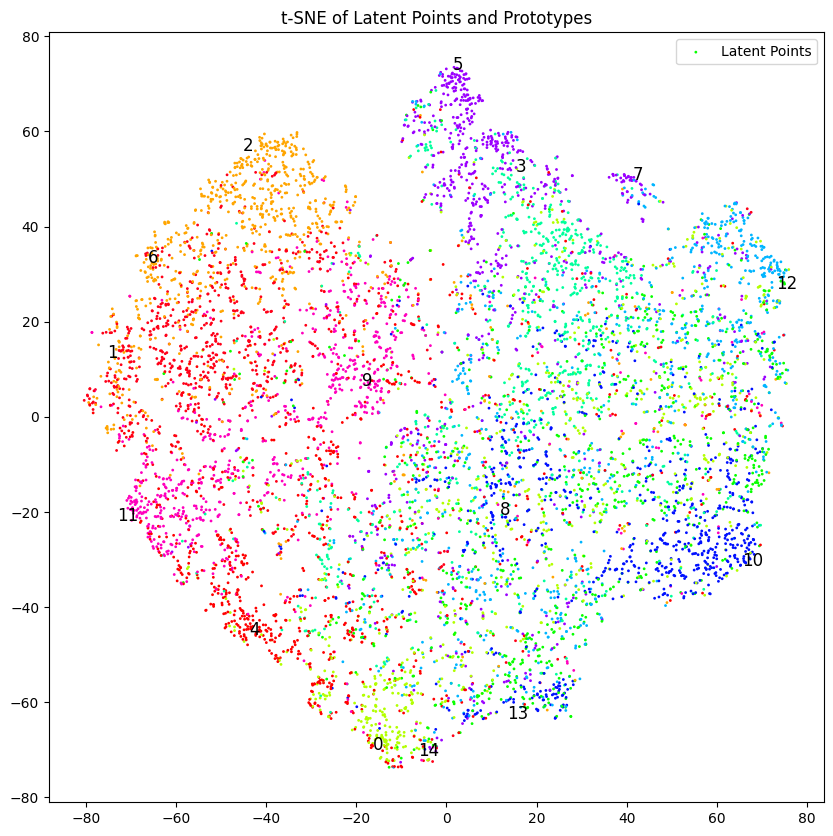

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state=0)
tsne_nd = torch.concat([features, swav_prototypes], axis=0)
tsne_2d = tsne.fit_transform(tsne_nd)

n_projs = len(features)
proj_2d, prot_2d = tsne_2d[:n_projs, :], tsne_2d[n_projs:, :]

cluster_labels = similarities.argmax(axis=1).cpu().numpy()

plt.figure(figsize=(10, 10))
plt.scatter(proj_2d[:, 0], proj_2d[:, 1], c= labels, cmap='hsv', label='Latent Points', s=1)
#plt.scatter(tsne_prot[:, 0], tsne_prot[:, 1], c='black', label='Prototypes', marker='.')
for i, (x, y) in enumerate(prot_2d):
    plt.text(x, y, i, color='black', fontsize=12, ha='center', va='center')

plt.legend()
plt.title("t-SNE of Latent Points and Prototypes")
plt.show()

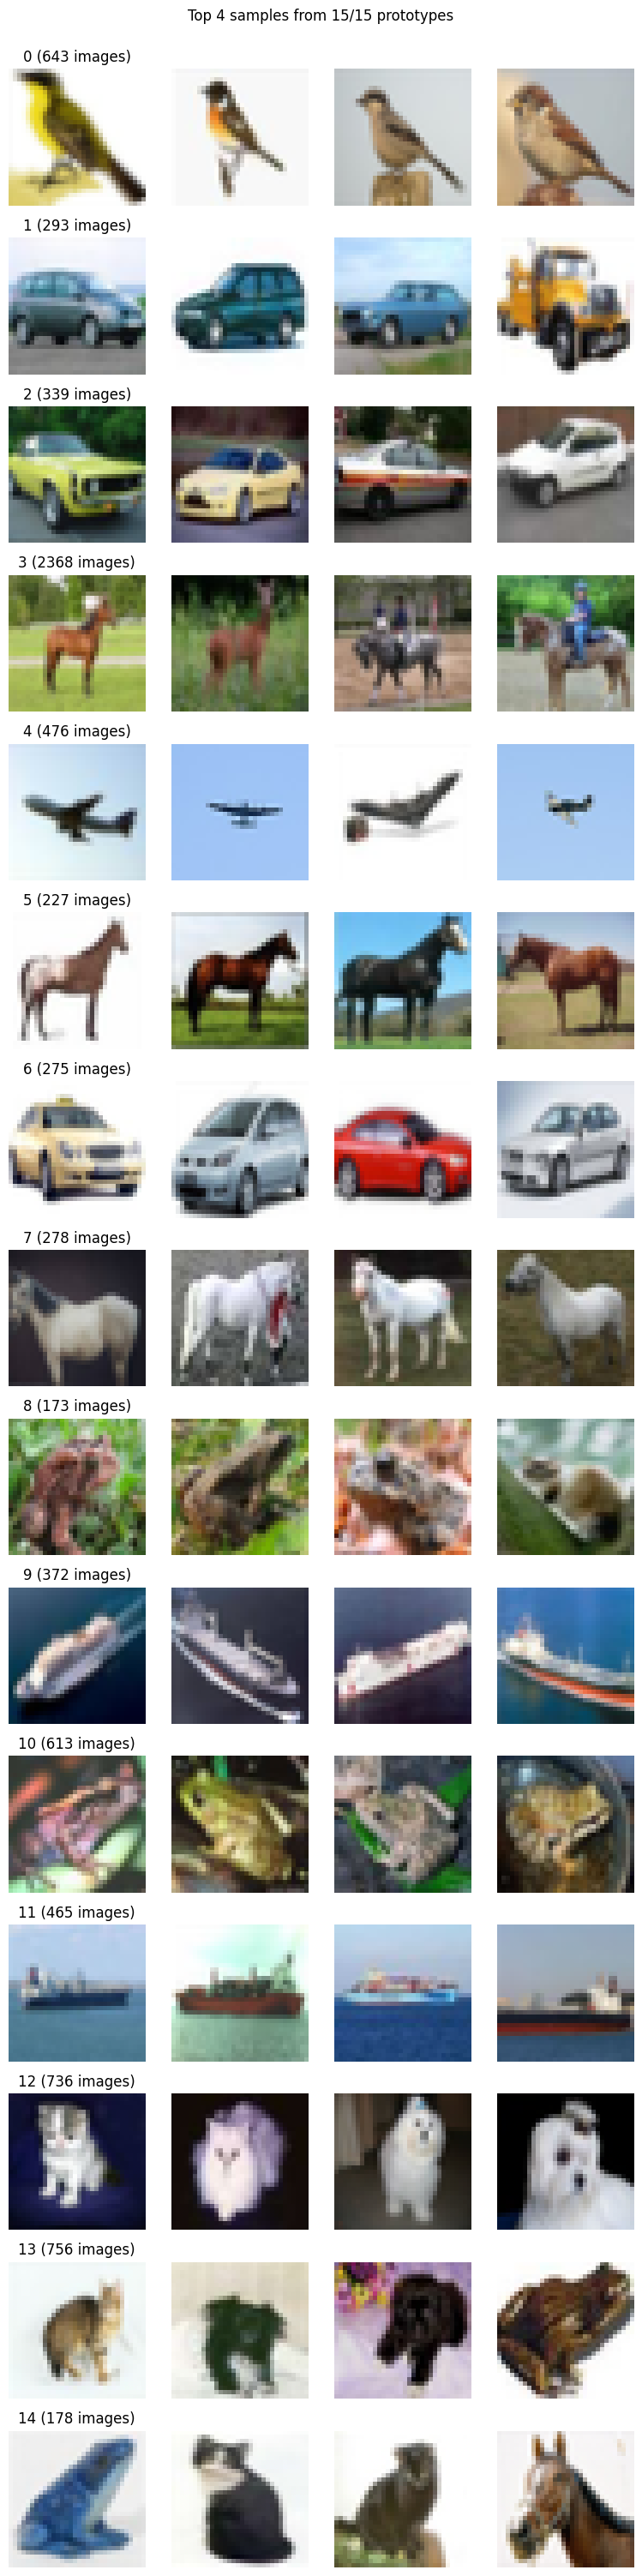

In [ ]:
n_plots = 4
cluster_assign = proto_assign.numpy()
cluster_conf = confidence
n_proto = 15

unique_prototypes = proto_assign.unique().type(torch.uint16).tolist()
n_rows = max(2, len(unique_prototypes))

fig, ax = plt.subplots(n_rows, n_plots, figsize=(2*n_plots, 2*n_rows), layout='tight')
fig.suptitle(f'Top {n_plots} samples from {n_rows}/{n_proto} prototypes', y=1)

for ax0_idx, prototype_plot in enumerate(unique_prototypes):

    ax0 = ax[ax0_idx]

    prototype_img_idxs = np.array([
        img_idx 
        for img_idx in range(len(cluster_assign)) 
        if cluster_assign[img_idx] == prototype_plot
    ])

    if cluster_conf is not None:
        prototype_img_conf = cluster_conf.numpy()[prototype_img_idxs]
        prototype_img_idxs = prototype_img_idxs[np.flip(np.argsort(prototype_img_conf))]
        img_idxs_plot = prototype_img_idxs[:n_plots]

    else:
            img_idxs_plot = np.random.choice(prototype_img_idxs,n_plots)

    total_images = len(prototype_img_idxs)
    
    ax0[0].set_title(f'{prototype_plot} ({total_images} images)')

    for ax1 in ax0:
        ax1.axis('off')

    for ax1_idx, img_idx in enumerate(img_idxs_plot):
        img = test_dataset[img_idx][0]
        # reshape to [C, H, W] to [H, W, C] 
        img = img.permute(1, 2, 0)
        ax0[ax1_idx].imshow(img)

# Exercícios / Experimentos

Para avaliar nossos experimentos vamos seguir duas abordagens. Você deve:

1. Treinar o modelo com sua modificação experimental.
2. Avaliar a qualidade usando o protocolo de avaliação linear (congelar o backbone, treinar um classificador linear).
3. Visualizar os embeddings da base de teste usando t-SNE ou UMAP para analisar a separação de classes.

Depois, explique o experimento escolhido e compartilhe seus resultados no [issue do github](https://github.com/liviameinhardt/deep-learning-course-fgv/issues/8).

Escolha um ou mais experimentos aqui (caso queira testar algo diferente, me avise):

1.  **Estratégia de múltiplos recortes (multi-crop)**
    * Altere a **resolução das visões** e o **número de recortes** (ex: 2 recortes grandes + 6 pequenos vs. apenas 2 grandes).
    * Compare como isso afeta a qualidade das representações.

2.  **Arquiteturas de backbone**
    * Teste diferentes backbones (ResNet18, ResNet50, EfficientNet).
    * Compare o tempo de treinamento e a acurácia sob avaliação linear.

3.  **Ablação de aumentações (augmentation)**
    * Remova uma das aumentações (ex: sem recorte aleatório, sem *color jitter*, sem *blur*) e observe o impacto.
    * Teste combinações personalizadas de aumentações.

4.  **Parâmetro de temperatura (τ)**
    * Altere a **temperatura no softmax** da perda (ex: 0.1, 0.5, 1.0).
    * Discuta como valores mais baixos vs. mais altos afetam a separabilidade dos clusters.

5.  **Número de protótipos**
    * Altere o número de protótipos (clusters) no SwAV.
    * Compare as representações ao usar menos vs. mais protótipos.

6.  **Implementação das Proporções**
    * Implemente a modificação do SwAV proposta por  [Rosa & Oliveira](https://cdn.aaai.org/ojs/20112/20112-13-24125-1-2-20220628.pdf) - também tem explicação simplificada no pdf do site.
    * Utilize as proporções do CIFAR e compare o treinamento com e sem proporções. 